In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

data=pd.read_csv('Crypto_historical_data.csv')
target_crypto=['Bitcoin', 'Ethereum', 'Litecoin']
data=data[data['name'].isin(target_crypto)]
print(data['name'].unique())
print(data)


['Ethereum' 'Bitcoin' 'Litecoin']
                            Date        Open        High         Low  \
0      2017-11-09 00:00:00+00:00  308.644989  329.451996  307.056000   
1      2017-11-10 00:00:00+00:00  320.670990  324.717987  294.541992   
2      2017-11-11 00:00:00+00:00  298.585999  319.453003  298.191986   
3      2017-11-12 00:00:00+00:00  314.690002  319.153015  298.513000   
4      2017-11-13 00:00:00+00:00  307.024994  328.415009  307.024994   
...                          ...         ...         ...         ...   
67702  2025-12-05 00:00:00+00:00   83.566628   84.104477   79.832222   
67703  2025-12-06 00:00:00+00:00   80.490448   82.456062   80.000427   
67704  2025-12-07 00:00:00+00:00   81.702011   83.647766   80.030922   
67705  2025-12-08 00:00:00+00:00   81.424095   84.363342   81.150002   
67706  2025-12-10 00:00:00+00:00   86.096802   86.096802   84.345825   

            Close      Volume   ticker      name  
0      320.884003   893249984  ETH-USD  Ethereum  

In [2]:
date_col = 'Date'
non_numeric_cols = ['ticker', 'name']  
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  
numeric_data = data[numeric_cols].copy() 
non_numeric_data = data[non_numeric_cols + [date_col]].copy()  
clear_numeric = numeric_data.copy()

for i in range(len(numeric_cols)):
    col = numeric_cols[i]  
    q1 = numeric_data[col].quantile(0.25)
    q3 = numeric_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = (numeric_data[col] >= lower_bound) & (numeric_data[col] <= upper_bound)
    clear_numeric = clear_numeric[mask]
remaining_indices = clear_numeric.index
clear_non_numeric = non_numeric_data.loc[remaining_indices].reset_index(drop=True)
clear_numeric = clear_numeric.reset_index(drop=True)
clear_combined = pd.concat([clear_non_numeric, clear_numeric], axis=1)
clear_combined = clear_combined.dropna()


df_clean=clear_combined
final_columns_order = [date_col] + numeric_cols + non_numeric_cols
df_clean = df_clean[final_columns_order]

print(df_clean['name'].unique())

['Ethereum' 'Bitcoin' 'Litecoin']


C:\Users\Денис\AppData\Local\Temp\ipykernel_10460\2197528434.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Денис\AppData\Local\Temp\ipykernel_10460\2197528434.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Денис\AppData\Local\Temp\ipykernel_10460\2197528434.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Денис\AppData\Local\Temp\ipykernel_10460\2197528434.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]



Матрица корреляции:
ticker   BTC-USD   ETH-USD   LTC-USD
ticker                              
BTC-USD  1.00000  0.458500  0.794880
ETH-USD  0.45850  1.000000  0.395623
LTC-USD  0.79488  0.395623  1.000000


<Axes: xlabel='ticker', ylabel='ticker'>

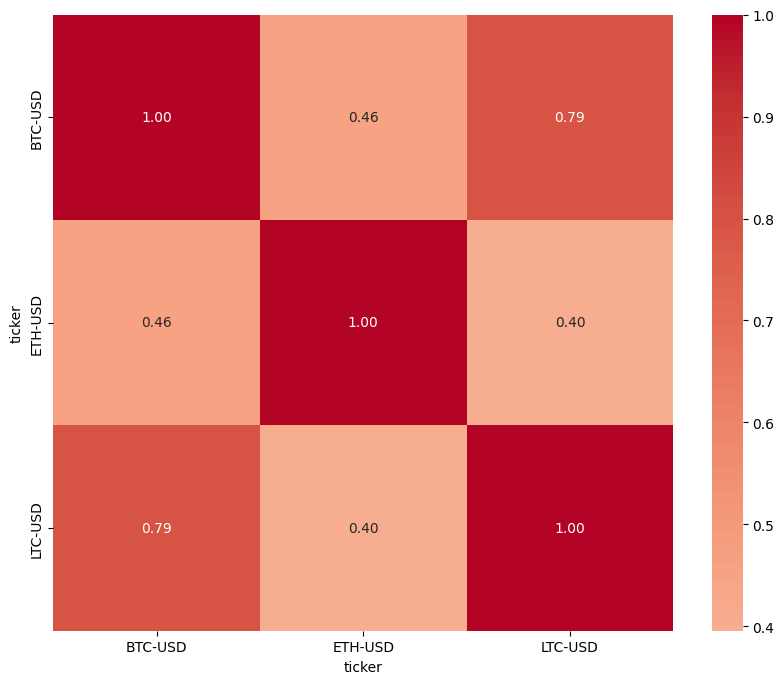

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

pivot_data = df_clean.pivot(index='Date', columns='ticker', values='Close')
correlation_matrix = pivot_data.corr()
print("\nМатрица корреляции:")
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Включаем подписи значений
            fmt='.2f',   # Формат чисел (2 знака после запятой)
            cmap='coolwarm',
            center=0
            )


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(
    df_clean, 
    test_size=0.2,  
    random_state=42,  
    shuffle=True  
)

LSTM Реализация

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def prepare_single_crypto_lstm(train_df, test_df, crypto_name='Bitcoin', 
                               sequence_length=60, feature_cols=['Close']):
    """
    Подготавливает данные для LSTM одной криптовалюты
    """
    # Фильтруем данные по криптовалюте
    train_crypto = train_df[train_df['name'] == crypto_name].copy()
    test_crypto = test_df[test_df['name'] == crypto_name].copy()
    
    print(f"\nКриптовалюта: {crypto_name}")
    print(f"  Тренировочные записи: {len(train_crypto)}")
    print(f"  Тестовые записи: {len(test_crypto)}")
    
    train_crypto = train_crypto.sort_values('Date')
    test_crypto = test_crypto.sort_values('Date')
    
    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    train_features = scaler.fit_transform(train_crypto[feature_cols].values)
    test_features = scaler.transform(test_crypto[feature_cols].values)
    
    # Функция создания последовательностей
    def create_sequences(data, seq_length):
        sequences = []
        targets = []
        
        for i in range(seq_length, len(data)):
            sequences.append(data[i-seq_length:i])
            targets.append(data[i, 0])  # Предсказываем Close цену
            
        return np.array(sequences), np.array(targets)
    
    # Создаем последовательности
    X_train, y_train = create_sequences(train_features, sequence_length)
    X_test, y_test = create_sequences(test_features, sequence_length)
    
    # Преобразуем в тензоры PyTorch
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)  # [batch, 1]
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(device)
    
    print(f"  Размерности X_train: {X_train.shape}")
    print(f"  Размерности y_train: {y_train.shape}")
    print(f"  Размерности X_test: {X_test.shape}")
    print(f"  Размерности y_test: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler

# Подготовка данных для Bitcoin
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Bitcoin',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)



Криптовалюта: Bitcoin
  Тренировочные записи: 1730
  Тестовые записи: 435
  Размерности X_train: torch.Size([1670, 60, 1])
  Размерности y_train: torch.Size([1670, 1])
  Размерности X_test: torch.Size([375, 60, 1])
  Размерности y_test: torch.Size([375, 1])


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CryptoLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, 
                 output_size=1, dropout=0.3, bidirectional=True):
        super(CryptoLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # 1. Первый LSTM слой
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        
        # 2. Второй LSTM слой (для извлечения дополнительных паттернов)
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * self.num_directions,
            hidden_size=hidden_size // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        
        # 3. BatchNorm слои
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * self.num_directions)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        
        # 4. Dropout слои
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout * 0.7)
        
        # 5. Полносвязные слои
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(hidden_size // 8, output_size)
        )
        
    def forward(self, x):
        # 1. Первый LSTM слой
        lstm1_out, _ = self.lstm1(x)  # [batch, seq_len, hidden*directions]
        
        # 2. Берем последний временной шаг из первого LSTM
        lstm1_last = lstm1_out[:, -1, :]  # [batch, hidden*directions]
        
        # 3. BatchNorm и Dropout
        lstm1_last = self.batch_norm1(lstm1_last)
        lstm1_last = self.dropout1(lstm1_last)
        
        # 4. Подготовка для второго LSTM
        # Повторяем lstm1_last для каждого временного шага
        context_expanded = lstm1_last.unsqueeze(1).repeat(1, x.size(1), 1)
        
        # 5. Второй LSTM слой
        lstm2_out, _ = self.lstm2(context_expanded)  # [batch, seq_len, hidden//2]
        lstm2_last = lstm2_out[:, -1, :]  # берем последний шаг
        
        # 6. BatchNorm и Dropout
        lstm2_last = self.batch_norm2(lstm2_last)
        lstm2_last = self.dropout2(lstm2_last)
        
        # 7. Полносвязные слои
        output = self.fc_layers(lstm2_last)
        
        return output

In [45]:
input_size = X_train.shape[2]  # Количество признаков
model = CryptoLSTM(
    input_size=input_size,
    hidden_size=64,
    num_layers=2,
    output_size=1,
    dropout=0.3
).to(device)

In [46]:
from torch.utils.data import DataLoader, TensorDataset
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [47]:

import torch
import numpy as np

# Добавьте этот код в функцию обучения:
def train_model(model, train_loader, test_loader, epochs=100):
    train_losses = []
    val_losses = []
    
    print("\n" + "="*60)
    print("ОБУЧЕНИЕ")
    print("="*60)
    
    
    for epoch in range(epochs):     
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Проверка размеров батча
            if batch_idx == 0 and epoch == 0:
                print(f"\nРазмер первого батча:")
                print(f"  batch_X: {batch_X.shape}")
                print(f"  batch_y: {batch_y.shape}")
            
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(batch_X)
            
            # Проверка выходов
            if batch_idx == 0 and epoch == 0:
                print(f"  outputs: {outputs.shape}")
                print(f"  outputs sample: {outputs[0].item():.6f}")
                print(f"  batch_y sample: {batch_y[0].item():.6f}")
            
            loss = criterion(outputs, batch_y)
            
            # Проверка loss
            if torch.isnan(loss):
                print(f"⚠️  NaN loss на батче {batch_idx}")
                break
            
            loss.backward()
            
            # Проверка градиентов
            if epoch == 0 and batch_idx == 0:
                total_grad_norm = 0
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.norm().item()
                        total_grad_norm += grad_norm
                        if grad_norm == 0:
                            print(f"⚠️  Нулевой градиент: {name}")
                
                print(f"  Общая норма градиентов: {total_grad_norm:.6f}")
            
            optimizer.step()
            train_loss += loss.item()
            batch_count += 1
        
        # Средний loss
        if batch_count > 0:
            avg_train_loss = train_loss / batch_count
        else:
            avg_train_loss = 0
        
        train_losses.append(avg_train_loss)
        
        # Валидация
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_batches += 1
        
        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
        else:
            avg_val_loss = 0
        
        val_losses.append(avg_val_loss)
        
        
        # Выводим каждую эпоху для дебага
        print(f'Epoch [{epoch+1:3d}/{epochs}] | '
              f'Train Loss: {avg_train_loss:.6f} | '
              f'Val Loss: {avg_val_loss:.6f}')
        
    
    
    return train_losses, val_losses

In [48]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: 0.191453
  batch_y sample: 0.509686
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 5.745146
Epoch [  1/100] | Train Loss: 0.040620 | Val Loss: 0.024886
Epoch [  2/100] | Train Loss: 0.020923 | Val Loss: 0.009772
Epoch [  3/100] | Train Loss: 0.018138 | Val Loss: 0.010627
Epoch [  4/100] | Train Loss: 0.015248 | Val Loss: 0.009870
Epoch [  5/100] | Train Loss: 0.014543 | Val Loss: 0.007514
Epoch [  6/100] | Train Loss: 0.013305 | Val Loss: 0.008490
Epoch [  7/100] | Train Loss: 0.013244 | Val Loss: 0.008495
Epoch [  8/100] | Train Loss: 0.012335 | Val Loss: 0.007202
Epoch [  9/100] | Train Loss: 0.011926 | Val Loss: 0.007220
Epoch [ 10/100] | Train Loss: 0.011432 | Val Loss: 0.009735
Epoch [ 11/100] | Train Loss: 0.011698 | Val Loss: 0.008156
Epoch [ 12/100] | Train Loss: 0.009717 | Val Loss: 0.009849
Epoch [ 13/1

In [49]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_predictions(y_true, y_pred, dataset_name):
    """Оценивает качество предсказаний"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAPE': mape}


train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


Тренировочные данные:
  RMSE: 745.0821
  MAPE: 19.68%

Тестовые данные:
  RMSE: 1049.2747
  MAPE: 18.73%


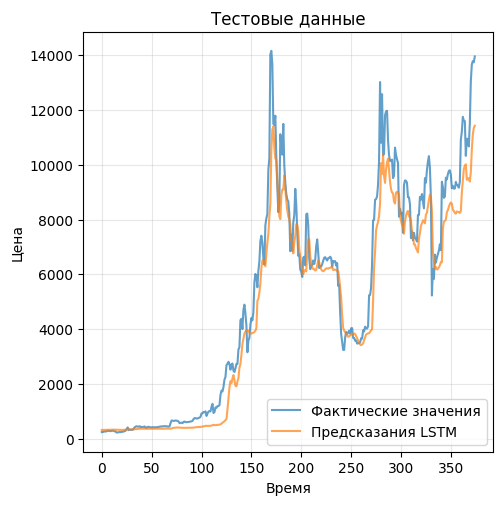

In [51]:
fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)


In [52]:
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Ethereum',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Криптовалюта: Ethereum
  Тренировочные записи: 2273
  Тестовые записи: 579
  Размерности X_train: torch.Size([2213, 60, 1])
  Размерности y_train: torch.Size([2213, 1])
  Размерности X_test: torch.Size([519, 60, 1])
  Размерности y_test: torch.Size([519, 1])


In [53]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: 0.268262
  batch_y sample: 0.320983
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 0.684267
Epoch [  1/100] | Train Loss: 0.004367 | Val Loss: 0.002751
Epoch [  2/100] | Train Loss: 0.004774 | Val Loss: 0.002501
Epoch [  3/100] | Train Loss: 0.004690 | Val Loss: 0.003019
Epoch [  4/100] | Train Loss: 0.004851 | Val Loss: 0.002761
Epoch [  5/100] | Train Loss: 0.004619 | Val Loss: 0.003174
Epoch [  6/100] | Train Loss: 0.004208 | Val Loss: 0.003126
Epoch [  7/100] | Train Loss: 0.004121 | Val Loss: 0.002712
Epoch [  8/100] | Train Loss: 0.004201 | Val Loss: 0.002533
Epoch [  9/100] | Train Loss: 0.005116 | Val Loss: 0.003197
Epoch [ 10/100] | Train Loss: 0.005272 | Val Loss: 0.003030
Epoch [ 11/100] | Train Loss: 0.004810 | Val Loss: 0.002945
Epoch [ 12/100] | Train Loss: 0.004905 | Val Loss: 0.002587
Epoch [ 13/1


Тренировочные данные:
  RMSE: 175.5941
  MAPE: 17.30%

Тестовые данные:
  RMSE: 239.2530
  MAPE: 20.39%


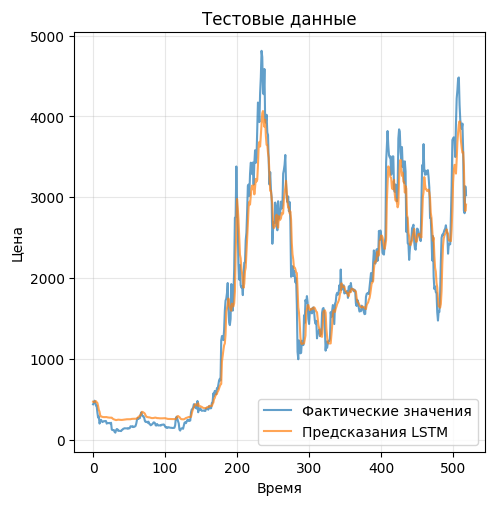

In [54]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)


In [55]:
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Litecoin',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Криптовалюта: Litecoin
  Тренировочные записи: 3292
  Тестовые записи: 810
  Размерности X_train: torch.Size([3232, 60, 1])
  Размерности y_train: torch.Size([3232, 1])
  Размерности X_test: torch.Size([750, 60, 1])
  Размерности y_test: torch.Size([750, 1])


In [56]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: 0.261896
  batch_y sample: 0.210275
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 0.762462
Epoch [  1/100] | Train Loss: 0.002545 | Val Loss: 0.001764
Epoch [  2/100] | Train Loss: 0.001918 | Val Loss: 0.001550
Epoch [  3/100] | Train Loss: 0.001767 | Val Loss: 0.001530
Epoch [  4/100] | Train Loss: 0.001613 | Val Loss: 0.001536
Epoch [  5/100] | Train Loss: 0.001562 | Val Loss: 0.001468
Epoch [  6/100] | Train Loss: 0.001527 | Val Loss: 0.001537
Epoch [  7/100] | Train Loss: 0.001490 | Val Loss: 0.001699
Epoch [  8/100] | Train Loss: 0.001667 | Val Loss: 0.001669
Epoch [  9/100] | Train Loss: 0.001483 | Val Loss: 0.001517
Epoch [ 10/100] | Train Loss: 0.001759 | Val Loss: 0.001947
Epoch [ 11/100] | Train Loss: 0.001573 | Val Loss: 0.001549
Epoch [ 12/100] | Train Loss: 0.001598 | Val Loss: 0.001544
Epoch [ 13/1


Тренировочные данные:
  RMSE: 9.1568
  MAPE: 26.36%

Тестовые данные:
  RMSE: 15.0202
  MAPE: 19.81%


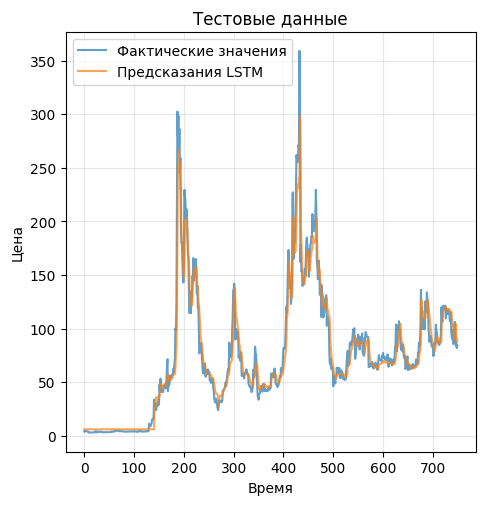

In [57]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)
